In [1]:
#import libraries.
import numpy as np
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
from tensorflow.python.keras.utils.data_utils import Sequence
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, Input, Lambda
from keras.wrappers.scikit_learn import KerasRegressor
import keras
from keras import regularizers, optimizers
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from keras.initializers import glorot_normal
# import sounddevice as sd
import tensorflow as tf
from mir_eval import separation 
from pystoi.stoi import stoi 
import h5py
from keras.callbacks import LearningRateScheduler, Callback, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
import math
from sklearn.utils import shuffle
from sklearn import preprocessing
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
#import libraries.
# import matplotlib.pyplot as plt
# from tabulate import tabulate
import time
import os
import librosa
from librosa.core import stft, istft
import time
import pickle
from keras import backend as K
from tensorflow.keras.models import load_model
# from keras.models import load_model

In [3]:
data_series = str(0)
fft_samples = 1025

In [4]:
#1
h5f = h5py.File('TSP/Predicted/predicted_TSP_Mask' + data_series + '.hdf5','r')
input_mask = h5f['predicted_TSP_Mask' + data_series ][0:3000]
h5f.close()
print(input_mask.shape)

(3000, 2050)


In [5]:
#2
h5f = h5py.File('TSP/Organized/concatenated/Second_set/Train2_TSP_clean_FFTs'  + data_series + '.hdf5','r')
clean_target = h5f['Train2_TSP_clean_FFTs'  + data_series ][:,0:3000]
h5f.close()
print(clean_target.shape)

(2050, 3000)


In [6]:
#3
h5f = h5py.File('TSP/Organized/concatenated/Second_set/Train2_TSP_mixed_FFT'  + data_series + '.hdf5','r')
input_mixed = h5f['Train2_TSP_mixed_FFT'  + data_series ][:,0:3000]
h5f.close()
print(input_mixed.shape)

(1025, 3000)


In [39]:
h5f = h5py.File('TSP/Predicted/Valid_predicted_TSP_Mask'  + data_series + '.hdf5','r')
valid_input_mask = h5f['Valid_predicted_TSP_Mask'  + data_series ][:]
h5f.close()
print(valid_input_mask.shape)

(21494, 2050)


In [8]:
h5f = h5py.File('TSP/Organized/concatenated/Valid_TSP_clean_FFTs'  + data_series + '.hdf5','r')
valid_clean_target = h5f['Valid_TSP_clean_FFTs'  + data_series ][:]
h5f.close()
print(valid_clean_target.shape)

(2050, 21494)


In [9]:
h5f = h5py.File('TSP/Organized/concatenated/Valid_TSP_mixed_FFT'  + data_series + '.hdf5','r')
valid_input_mixed = h5f['Valid_TSP_mixed_FFT'  + data_series ][:]
h5f.close()
print(valid_input_mixed.shape)

(1025, 21494)


In [10]:
# a = clean_target[0:1025]
# b = clean_target[1025:]
# true_mask = a/(a+b)
# true_mask = np.concatenate((true_mask,b/(a+b)), axis = 0)
# print(true_mask.shape)

(2050, 3000)


In [11]:
# a = valid_clean_target[0:1025]
# b = valid_clean_target[1025:]
# valid_true_mask = a/(a+b)
# valid_true_mask = np.concatenate((valid_true_mask,b/(a+b)), axis = 0)
# print(valid_true_mask.shape)

(2050, 21494)


In [12]:
# X = X.T
# X_valid = X_valid.T

In [12]:
def loss_DNNC(y_true, y_pred, Lambda = 0.1):
    loss = K.sum(K.square(y_true - y_pred)) 
    - Lambda * (K.sum(K.square(y_true[0:fft_samples,:] - y_pred[fft_samples:,:])) + K.sum(K.square(y_true[fft_samples:,:] - y_pred[0:fft_samples,:])))
    return loss

In [17]:
from keras.backend import *
def mult(args):
    mask, mixed = args
    output0 = mask[:,0:(mask.shape[1]//2)] * mixed[:]
    output1 = mask[:,(mask.shape[1]//2):(mask.shape[1])] * mixed[:]
    return K.concatenate([output0, output1], axis=1)

In [34]:
# create model
X_dim= 2050
y_dim = 2050
h_A = [4100, 4100, 4100]
estimator_C = Sequential()
# input0 : mask
# np.min(input_mask.shape)
network_mask_input = Input(shape=(2050,),name='input_mask')
                           
# input1 : clean voice\
# np.min(input_mixed.shape)
network_mixed_input = Input(shape=(1025,),name='input_mixed')

 
# the first branch operates on the first input
layer1 = Dense(h_A[0], activation="sigmoid")(network_mask_input)
layer2 = Dense(h_A[1], activation="sigmoid")(layer1)
layer3 = Dense(h_A[2], activation="sigmoid")(layer2)
layer_mask = Dense(np.min(clean_target.shape), activation="sigmoid")(layer3)
output_layer = Lambda(mult,output_shape = (2050,))([layer_mask, network_mixed_input])
 
estimator_C = Model(inputs=[network_mask_input, network_mixed_input], outputs=output_layer)

estimator_C.compile(loss=loss_DNNC, optimizer='adam')
estimator_C.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_mask (InputLayer)         (None, 2050)         0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 4100)         8409100     input_mask[0][0]                 
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 4100)         16814100    dense_13[0][0]                   
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 4100)         16814100    dense_14[0][0]                   
__________________________________________________________________________________________________
dense_16 (

In [19]:
class SGDLearningRateTracker(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print('LR= ', K.eval(self.model.optimizer.lr))
        _lr = tf.to_float(self.model.optimizer.lr, name='ToFloat')
        _decay = tf.to_float(self.model.optimizer.decay, name='ToFloat')
        _iter = tf.to_float(self.model.optimizer.iterations, name='ToFloat')

        lr = K.eval(_lr * (1. / (1. + _decay * _iter)))
        print(' - LR: {:.6f}\n'.format(lr))
        
        
  
model_saving_filepath_adam = "Models/Two_stage/C/saved-model-adam-{epoch:03d}-{loss:.4f}.hdf5"
model_saving_checkpoint_adam = ModelCheckpoint(model_saving_filepath_adam, monitor='loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

model_saving_filepath_SGD = "Models/Two_stage/C/adam_SBS/saved-model-SGD-{epoch:03d}-{loss:.4f}.hdf5"
model_saving_checkpoint_SGD = ModelCheckpoint(model_saving_filepath_SGD, monitor='loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

model_saving_filepath_RMSprop = "Models/Two_stage/C/adam_SBS/saved-model-RMSprop-{epoch:03d}-{loss:.4f}.hdf5"
model_saving_checkpoint_RMSprop = ModelCheckpoint(model_saving_filepath_RMSprop, monitor='loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

model_saving_filepath_Adagrad = "Models/Two_stage/C/adam_SBS/saved-model-Adagrad-{epoch:03d}-{loss:.4f}.hdf5"
model_saving_checkpoint_Adagrad = ModelCheckpoint(model_saving_filepath_Adagrad, monitor='loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

model_saving_filepath_Adadelta = "Models/Two_stage/C/adam_SBS/saved-model-Adadelta-{epoch:03d}-{loss:.4f}.hdf5"
model_saving_checkpoint_Adadelta = ModelCheckpoint(model_saving_filepath_Adadelta, monitor='loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)



 	
ES_calback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [44]:
# # seed = 1
# # np.random.seed(seed)
# print("^^^^^^^^^^^^^^^^^^^^^ Training with 5-fold on mixed0^^^^^^^^^^^^^^^^^^^^^")
batch_size = 100
# tic = time.time()
# estimator_A = KerasRegressor(build_fn=DNN_A, epochs = 10, batch_size=batch_size, shuffle = True, verbose=1)
# kfold = KFold(n_splits=2, random_state=None)
# kfold = KFold(n_splits=5)
# results = cross_val_score(estimator_A, X.T, y.T, cv=kfold)
# print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))
# toc_fold = time.time()

print("^^^^^^^^^^^^^^^^^^^^^ Training on mixed5^^^^^^^^^^^^^^^^^^^^^")

callbacks_list = [model_saving_checkpoint_adam, ES_calback]
history = estimator_C.fit({'input_mask':input_mask, 'input_mixed':input_mixed.T}, y=clean_target.T,
                          validation_data= ({'input_mask':valid_inout_mask, 'input_mixed':valid_input_mixed.T}, valid_clean_target.T),
                          epochs = 2, shuffle = True, batch_size=batch_size, steps_per_epoch=None, verbose = 1, callbacks= callbacks_list)
# toc_adam = time.time(
# estimator_A.save_weights('model_weights.h5')
print("---------------------------second part of training---------------------------")
# estimator_A.optimizer = optimizers.SGD()
# # estimator_A.load_weights('model_weights.h5')
# callbacks_list = [model_saving_checkpoint_SGD, ES_calback]
# history1 = estimator_A.fit(X.T, Mask.T, validation_data=(X_valid.T, Mask_valid.T), epochs=100, shuffle = True, batch_size=batch_size, steps_per_epoch=None, verbose = 1, callbacks= callbacks_list) 

# estimator_A.optimizer = optimizers.RMSprop()
# # estimator_A.load_weights('model_weights.h5')
# callbacks_list = [model_saving_checkpoint_RMSprop, ES_calback]
# history1 = estimator_A.fit(X.T, Mask.T, validation_data=(X_valid.T, Mask_valid.T), epochs=100, shuffle = True, batch_size=batch_size, steps_per_epoch=None, verbose = 1, callbacks= callbacks_list) 

# estimator_A.optimizer = optimizers.Adagrad()
# # estimator_A.load_weights('model_weights.h5')
# callbacks_list = [model_saving_checkpoint_Adagrad, ES_calback]
# history1 = estimator_A.fit(X.T, Mask.T, validation_data=(X_valid.T, Mask_valid.T), epochs=100, shuffle = True, batch_size=batch_size, steps_per_epoch=None, verbose = 1, callbacks= callbacks_list) 

# estimator_A.optimizer = optimizers.Adadelta()
# # estimator_A.load_weights('model_weights.h5')
# callbacks_list = [model_saving_checkpoint_Adadelta, ES_calback]
# history1 = estimator_A.fit(X.T, Mask.T, validation_data=(X_valid.T, Mask_valid.T), epochs=100, shuffle = True, batch_size=batch_size, steps_per_epoch=None, verbose = 1, callbacks= callbacks_list) 



# toc_fit = time.time()

^^^^^^^^^^^^^^^^^^^^^ Training on mixed5^^^^^^^^^^^^^^^^^^^^^
Train on 3000 samples, validate on 21494 samples
Epoch 1/2
3000/3000 [==============================] - 32s 11ms/step - loss: 157267.1643 - val_loss: 410657.8766
Epoch 2/2
3000/3000 [==============================] - 32s 11ms/step - loss: 154947.0742 - val_loss: 416958.7077
---------------------------second part of training---------------------------


In [69]:
print('Time= ', (toc_adam - tic)/3600)
print('Time= ', (toc_fit - tic)/3600)
# print("tIME OF K-FOLD=", (toc_fold - tic)/60)
# print("tIME OF FIT=", (toc_fit - tic)/60)

Time=  0.4218147822883394
Time=  0.4218148082494736


In [25]:
estimator_A.model.save('Models/Two_stage/TSP_model3.h5')

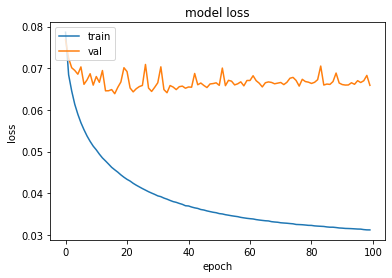

In [70]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

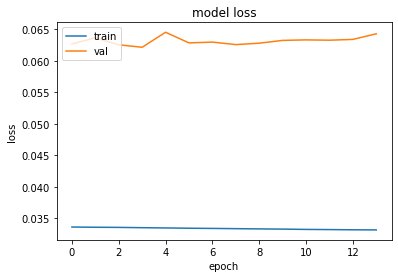

In [52]:

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [99]:
estimator_A.model.save_weights('Models/Two_stage/weights12.h5')

In [9]:
estimator_A = load_model('Models/Two_stage/trained_model19.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [ ]:
# two_opt_filepath="half_trained.hdf5"
# two_opt_checkpoint = ModelCheckpoint(two_opt_filepath, monitor = 'loss', verbose = 0, save_best_only = True, mode = 'min') 
# callbacks_list = [two_opt_checkpoint]
# callbacks_list = [changer]

fit


# new_model = load_model(two_opt_filepath)
# two_opt_checkpoint = ModelCheckpoint(two_opt_filepath, monitor = 'loss', verbose=1, save_best_only=True, mode='min')
# callbacks_list = [two_opt_checkpoint]
# new_model.optimizer = optimizers.SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True)
# history_sgd = new_model.fit(X.T, Mask.T, shuffle = True, epochs = 10, batch_size=10,  steps_per_epoch=None, callbacks=callbacks_list)
# estimator_A.fit (X.T, y.T, shuffle = True, batch_size=100,  steps_per_epoch=None, callbacks = [changer])
# prediction = estimator_A.predict(X_test)
